# Boston Crime Data Project: Examining Fraud Crimes from 2015 to Present

### Presented by Cristina Lucin

## Project Overview
This project was created to examine crime data from the City of Boston. Specifically, this project focuses on examining crime data collected by the City of Boston and examining trends in fraud crime occurences at several periods. The onset of the COVID pandemic and it's impact is seen through the visualization of this data, which leads to further questions about crime data forecasting before and after the pandemic, both within Fraud crimes and crime rates in general

## Goals
### Create deliverables:

* READ ME
* Final Report
* Functional wrangle.py, explore.py, and model.py files
* Acquire data from Analyze Boston Website
* Prepare and split the data
* Explore the data and define hypotheses, running appropriate statistical tests to accept or reject each null hypothesis
* Fit and train three (3) time-series models to predict the amount of fraud crimes on validation data
* Evaluate the models by comparing their performance validation data utilizing RMSE score
* Select the best model and evaluate it on test data
* Develop and document findings, takeaways, recommendations and next steps

In [1]:
#General DS Imports
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import statsmodels.api as sm
import scipy.stats as stats

# working with dates
from datetime import datetime
# to evaluated performance using rmse
from sklearn.metrics import mean_squared_error
from math import sqrt 
# holt's linear trend model. 
from statsmodels.tsa.api import Holt, ExponentialSmoothing

#My imports
import model as m
import wrangle as w
import explore as e

#warnings
import warnings
warnings.filterwarnings('ignore')
# plotting defaults
#define font family to use for all text
plt.rcParams['font.sans-serif'] = ['Verdana']
plt.rc('figure', figsize=(12, 8))
plt.style.use('seaborn-darkgrid')
from IPython.display import Image

# Aquire
* Data aquired from data.boston.gov 'Crime Incident Reports as .CSV files by year
* Crime Incident Reports were collected beginning in 2015, and the data spans to present
* I combined the annual CSV files into one CSV, containing 652,418 rows and 17 features before cleaning
* Each row represents a crime reported to Boston Police (see further explanation re: Unique Incident Numbers)
* Each columns represents a feature of the crime, such as offense type, location, or time the crime occured

# Prepare
###### Prepare Actions:
* Renamed columns to improve readability
* Checked that column data types were appropriate, changed data types when necessary
* Removed white space from values in object columns
* Checked for null values in the data, imputing where appropriate (location null values were not addressed for this iteration)
* Outliers were not removed in this iteration
* Utilized string functions to clean column data information

In [2]:
#Import our data from a .csv file, take a peek
df = w.get_clean_data()
df.head()

,incident_number,offense_code,offense_code_group,offense_description,district,reporting_area,shooting,occurred_on_date,year,month,day_of_week,hour,ucr_part,street,lat,long,location
0,I192068249,2647,other,threats to do bodily harm,B2,280,0,2015-08-28 10:20:00,2015,8,Friday,10,Part Two,WASHINGTON ST,42.330119,-71.084251,"(42.33011862, -71.08425106)"
1,I192061894,1106,confidence games,fraud - credit card / atm fraud,C11,356,0,2015-08-20 00:00:00,2015,8,Thursday,0,Part Two,CHARLES ST,42.300605,-71.061268,"(42.30060543, -71.06126785)"
2,I192038828,1107,fraud,fraud - impersonation,A1,172,0,2015-11-02 12:24:00,2015,11,Monday,12,Part Two,ALBANY ST,42.334288,-71.072395,"(42.33428841, -71.07239518)"
3,I192008877,1107,fraud,fraud - impersonation,E18,525,0,2015-07-31 10:00:00,2015,7,Friday,10,Part Two,WINGATE RD,42.237009,-71.129566,"(42.23700950, -71.12956606)"
4,I182090828,1102,fraud,fraud - false pretense / scheme,D4,159,0,2015-12-01 12:00:00,2015,12,Tuesday,12,Part Two,UPTON ST,42.342432,-71.072258,"(42.34243222, -71.07225766)"


### This dataframe, combined from Boston Crime data from 2015 to present, contains approximately 650,000 rows. Cleaning and imputing removed all null values except a small percentage within location data (3.5 percent). I elected to keep these nulls, and re-evaluate for future projects using this data

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 652418 entries, 0 to 652417
Data columns (total 17 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   incident_number      652418 non-null  object 
 1   offense_code         652418 non-null  int64  
 2   offense_code_group   652418 non-null  object 
 3   offense_description  652418 non-null  object 
 4   district             648116 non-null  object 
 5   reporting_area       652418 non-null  object 
 6   shooting             652418 non-null  int64  
 7   occurred_on_date     652418 non-null  object 
 8   year                 652418 non-null  int64  
 9   month                652418 non-null  int64  
 10  day_of_week          652418 non-null  object 
 11  hour                 652418 non-null  int64  
 12  ucr_part             652418 non-null  object 
 13  street               640529 non-null  object 
 14  lat                  629888 non-null  float64
 15  long             

### Unique incidents in this data

In [4]:
#Number of unique incidents in this data
df.incident_number.nunique()

610345

### 93.55 percent of the data involve unique incidents, meaning the vast majority of the data represents one row as one crime reported. Some of the data, where an incident number occurs multiple times, involve more serious offenses that are likely required to be tracked (arrests, firearm violations, aggravated assault):

In [5]:
#find duplicate rows across all columns
duplicateRows = df[df.duplicated()]
duplicateRows

,incident_number,offense_code,offense_code_group,offense_description,district,reporting_area,shooting,occurred_on_date,year,month,day_of_week,hour,ucr_part,street,lat,long,location
1250,I152107190,413,aggravated assault,assault - aggravated - battery,B3,427,1,2015-12-29 08:47:00,2015,12,Tuesday,8,Part One,WILMORE ST,42.277964,-71.092463,"(42.27796370, -71.09246318)"
1252,I152107190,111,homicide,"murder, non-negligient manslaughter",B3,427,1,2015-12-29 08:47:00,2015,12,Tuesday,8,Part One,WILMORE ST,42.277964,-71.092463,"(42.27796370, -71.09246318)"
1254,I152107190,3125,warrant arrests,warrant arrest,B3,427,1,2015-12-29 08:47:00,2015,12,Tuesday,8,Part Three,WILMORE ST,42.277964,-71.092463,"(42.27796370, -71.09246318)"
1256,I152107190,1501,firearm violations,"weapon - firearm - carrying / possessing, etc",B3,427,1,2015-12-29 08:47:00,2015,12,Tuesday,8,Part Two,WILMORE ST,42.277964,-71.092463,"(42.27796370, -71.09246318)"
2438,I152105851,413,aggravated assault,assault - aggravated - battery,E13,302,1,2015-12-23 15:39:00,2015,12,Wednesday,15,Part One,CENTRE ST,42.322838,-71.100967,"(42.32283759, -71.10096723)"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
353245,I070720870-00,3125,warrant arrests,warrant arrest,B2,318,0,2018-12-13 00:00:00,2018,12,Thursday,0,Part Three,BROOKLEDGE ST,42.309563,-71.089902,"(42.30956305, -71.08990197)"
353246,I070720870-00,3125,warrant arrests,warrant arrest,B2,318,0,2018-12-13 00:00:00,2018,12,Thursday,0,Part Three,BROOKLEDGE ST,42.309563,-71.089902,"(42.30956305, -71.08990197)"
353248,I070720870-00,802,simple assault,assault & battery,B2,318,0,2018-12-13 00:00:00,2018,12,Thursday,0,Part Two,BROOKLEDGE ST,42.309563,-71.089902,"(42.30956305, -71.08990197)"
353249,I070720870-00,3125,warrant arrests,warrant arrest,B2,318,0,2018-12-13 00:00:00,2018,12,Thursday,0,Part Three,BROOKLEDGE ST,42.309563,-71.089902,"(42.30956305, -71.08990197)"


## Extracting Fraud Crimes

#### I experimented with different methods of quantifying and specifying fraud crimes within this dataset. Several features that were important were:

- **"offense_code"**: Boston Police numeric offense codes to identify a crime type/subtype. Documentation provided with this data gave key/value information indicating fraud type crimes:
    - 1101 (Passing worthless checks) to 1109 (Wire Fraud), inclusive (ten (10) offense codes indicating fraud charges)
    - Link to more information: __[RMS Offense Codes](https://data.boston.gov/dataset/crime-incident-reports-august-2015-to-date-source-new-system/resource/3aeccf51-a231-4555-ba21-74572b4c33d6)__

- **"offense_code_group"**: Boston Police internal categorization of offense description
    - This field had approximately 300,000 null values
    
- **"offense_description"**: Primary descriptor of incident    

- Link to more information: __[Crime Incident Field Explanation](https://data.boston.gov/dataset/crime-incident-reports-august-2015-to-date-source-new-system/resource/9c30453a-fefa-4fe0-b51a-5fc09b0f4655)__

#### **I chose to use utilize all rows that contained "fraud" within the offense_description field, as this method returned the most results:**

In [6]:
#Creating a new dataframe for only offenses containing fraud in their crime description:
fraud_df = w.create_fraud_df(df)
fraud_df.head()

,incident_number,offense_code,offense_code_group,offense_description,district,reporting_area,shooting,year,month,day_of_week,hour,ucr_part,street,lat,long,location,count_of_crime
date,,,,,,,,,,,,,,,,,
2015-06-15,I152054354,1106,confidence games,fraud - credit card / atm fraud,D4,624,0,2015,6,Monday,17,Part Two,LANSDOWNE ST,42.347174,-71.096444,"(42.34717363, -71.09644390)",1
2015-06-15,I152049560,1102,fraud,fraud - false pretense / scheme,E18,519,0,2015,6,Monday,12,Part Two,RIVER ST,42.257191,-71.120018,"(42.25719149, -71.12001776)",1
2015-06-15,I162055778,1102,fraud,fraud - false pretense / scheme,D4,159,0,2015,6,Monday,9,Part Two,DARTMOUTH ST,42.342830,-71.073747,"(42.34283015, -71.07374670)",1
2015-06-15,I152049596,1106,confidence games,fraud - credit card / atm fraud,B3,470,0,2015,6,Monday,13,Part Two,COLORADO ST,42.277793,-71.099172,"(42.27779311, -71.09917239)",1
2015-06-15,I152049603,1102,fraud,fraud - false pretense / scheme,D4,128,0,2015,6,Monday,13,Part Two,STUART ST,42.349836,-71.071051,"(42.34983631, -71.07105135)",1


In [7]:
#These offenses contained 21, 247 crimes from June 2015 to present
fraud_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 21247 entries, 2015-06-15 to 2022-12-08
Data columns (total 17 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   incident_number      21247 non-null  object 
 1   offense_code         21247 non-null  int64  
 2   offense_code_group   21247 non-null  object 
 3   offense_description  21247 non-null  object 
 4   district             21109 non-null  object 
 5   reporting_area       21247 non-null  object 
 6   shooting             21247 non-null  int64  
 7   year                 21247 non-null  int64  
 8   month                21247 non-null  int64  
 9   day_of_week          21247 non-null  object 
 10  hour                 21247 non-null  int64  
 11  ucr_part             21247 non-null  object 
 12  street               21166 non-null  object 
 13  lat                  21049 non-null  float64
 14  long                 21049 non-null  float64
 15  location           

# Exploration

##### Train Test Split based on Pandemic Starting:
* On March 10, 2020, Governor Baker declared a state of emergency
* On March 15, 2020, Mayor Marty Walsh declared a state of emergency for the city of Boston
* Since the timeline is so close, I will elect to use March 15, 2020 to begin test data
* Validate data will be March 15, 2019 to March 14, 2020 (One year)
* Train data will be from March 15, 2017 to March 15, 2019 (Two Years)

In [8]:
#Train Test Split
train, validate, test = e.train_validate_test_split(fraud_df)

In [9]:
#Amount of observations in train, validate, test
print(f'Train has {len(train)} days')
print(f'Validate has {len(validate)} days')
print(f'Test has {len(validate)} days')

Train has 730 days
Validate has 364 days
Test has 364 days


___

## Question 1: What was the average fraud crime rate in the two years immediately prior to the pandemic?

### The mean number of fraud crimes occuring per day before the pandemic was 7.72, with a median value of 7.

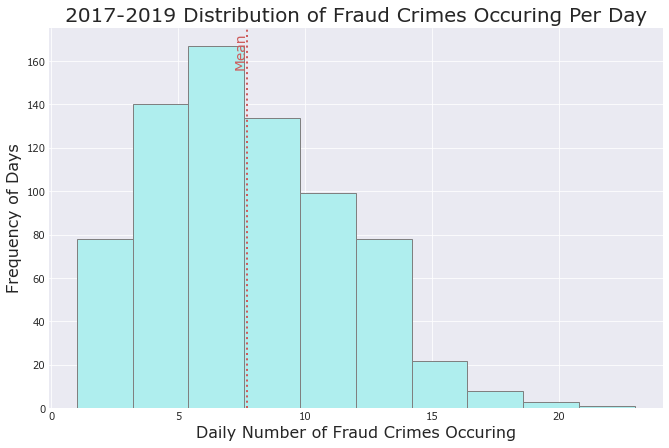

In [10]:
#Visualize distribution of target variable 
e.target_dist_viz(train)

## Question 2: Are certain months more likely to demonstrate greater reported fraud crimes?

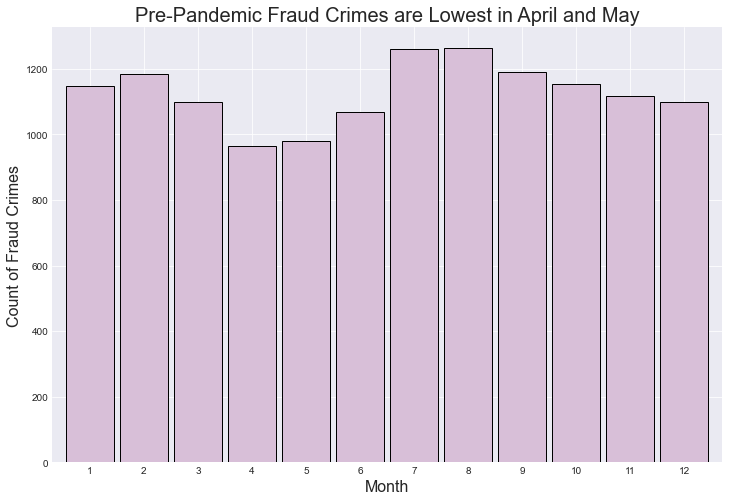

In [11]:
e.monthly_crime_hist(fraud_df)

### Comparing Fraud Crimes from April  to the all Pre-Pandemic Fraud Crimes

* Count of Crimes is a continuous variable, and we have one sample, so a one sample T-Test is required. 
* I used a 95% confidence interval (alpha value .05)

Hypotheses:

$H_0$: **Mean Fraud crime rate in for april is greater than or equal to fraud crime rates of the population (entire dataset)**

$H_a$: **Mean Fraud crime rate for april is less than fraud crime rates of the population (all other months)**

In [12]:
e.get_april_ttest(fraud_df)

t-statistic:1.205, P-Value:0.115, alpha=0.05


#### Given the P=Value is greater than alpha, we can conclude that there is not a significant difference between the mean fraud crime rate in April and the population

## Question 3: Do Fraud Crimes follow a seasonal pattern?

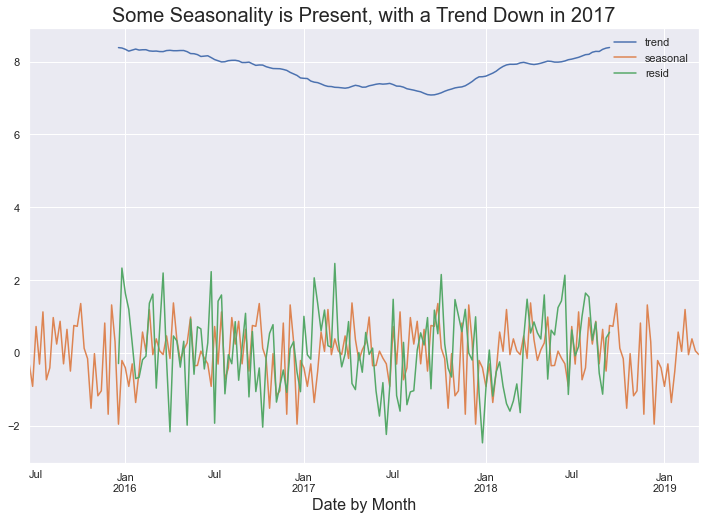

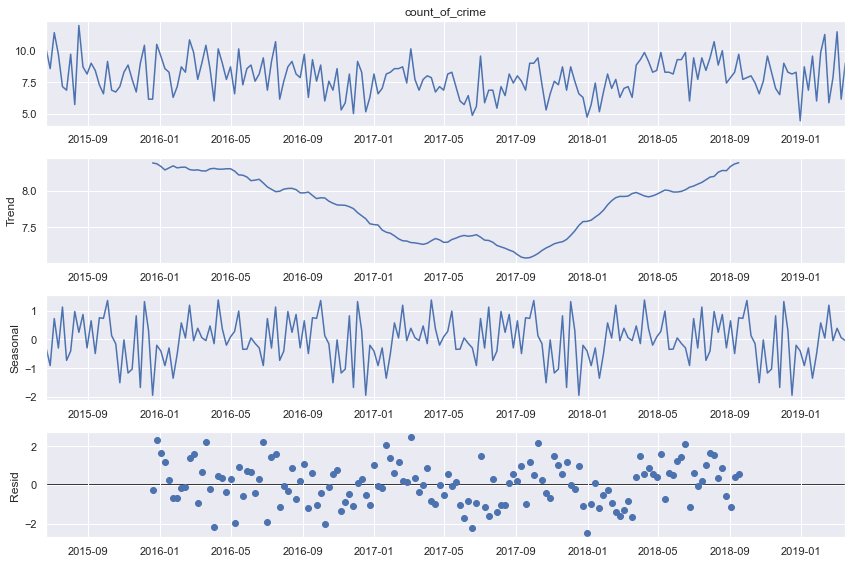

In [13]:
e.decomp_viz(fraud_df)

#### Though there is a sesonal component present in this data, there is also a pattern present in the residuals, which could indicate that there is no seasonality in this data

## Question 4: Is the downtrend seen in 2017 significant?

### Comparing Fraud Crimes from 2017 to Fraud Crimes from the entire dataset

* Count of Crimes is a continuous variable, and we have one sample, so a one sample T-Test is required. 
* I used a 95% confidence interval (alpha value .05)

Hypotheses:

$H_0$: **Mean Fraud crime rate in 2017 is greater than or equal to fraud crime rates of the population (entire dataset)**

$H_a$: **Mean Fraud crime rate in 2017 is less than fraud crime rates of the population (entire dataset)**

In [14]:
e.get_2017_ttest(fraud_df)

t-statistic:-2.504, P-Value:0.006, alpha=0.05


____

# Exploration Summary

* The average amount of fraud crimes occuring per day in Boston from 2017-2019 was 7.72, with a median of 7
* 2017 appeared to show a decrease in Fraud Crimes
* April and May had the lowest amount of fraud crimes reported, but this was not significant
* There isn't much seasonality in this data
* Resampling at a different time interval could improve this

____

# Modeling
* I will utilize RMSE as the evaluation metric
* I will use five different model types and various hyperparameter configurations
* Models are evaluated on validation data
* The model that performs the best will then be evaluated on test data
* **Baseline for modeling will be simple average**

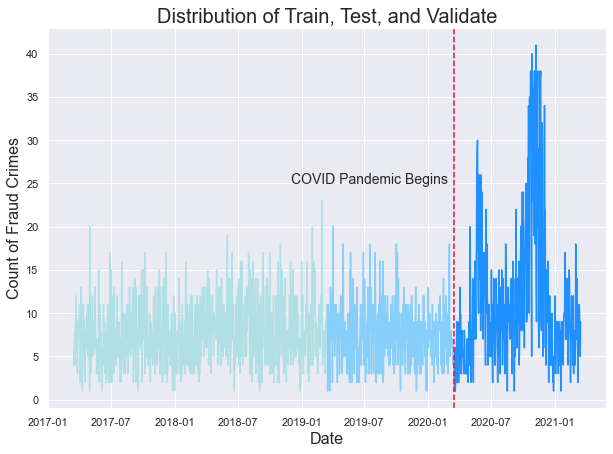

In [15]:
e.train_test_viz(train, validate, test)

## Model Performance

### Simple Average and Moving Averages

In [16]:
scores = m.eval_timeseries_models(train,validate, test)
scores

,model_name,train_score,validate_score
0,simple_average,4,3
1,30 d moving_average,4,4
2,90 d moving_average,4,4


##### 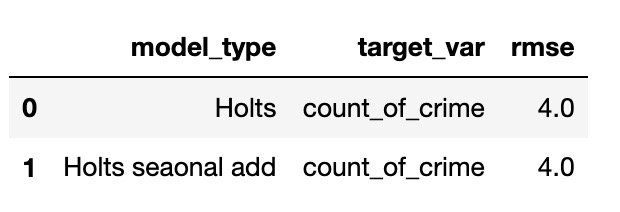

#### Holt's Linear and Holt's Seasonal Models also had RMSE validate values as 4.


____

# Comparing Models
* The baseline model of simple average was the best, with an RMSE score of 3
* Moving averages and Holt's linear and seasonal model performed similarly 
* **Simple average** will be used on test data

### Evaluating the simple model's performance on test

In [17]:
#Running simple model on train, validate AND test
m.eval_simple_test(train,validate,test)

,model_name,train_score,validate_score,test_score
0,simple_average,4,3,9


## Modeling Summary
* All models performed similarly on train, and validate
* Simple Average model, the baseline, was chosen for test
* Simple Average performed very poorly on test data, with a RMSE score of 9 (compared with 3 on validation data)

### An exploration of "Test" data post-modeling--Looking at all data available (2015-present)

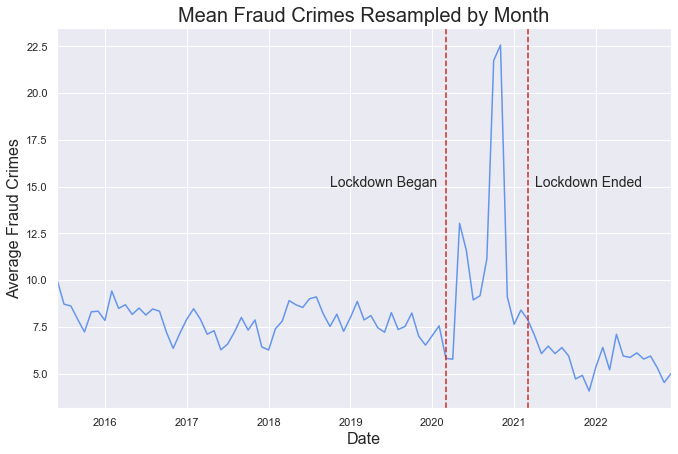

In [18]:
##Resample by month to visualize 2015-2022 fraud crimes
e.monthly_fraud_viz(fraud_df)

## Takeaways:
* Our model for predicting fraud crimes using a simple average was fairly effective
* Fraud crimes spiked during the pandemic
* This visualization shows that since lockdown restrictions were eased in Boston in the spring of 2021, Fraud crimes appears to be **decreasing** 

### Comparing Fraud Crimes from pre-pandemic levels to post-pandemic levels

* Count of Crimes is a continuous variable, and both populations are independent, so an independent T-Test is required. 
* I used a 95% confidence interval (alpha value .05)
* Variances were tested and not equal, and indicated in testing parameter

Hypotheses:

$H_0$: **Fraud crime rates pre-pandemic are less than or equal to fraud crime rates post pandemic**

$H_a$: **Fraud crime rates pre-pandemic are greater than fraud crime rates post pandemic.**

In [19]:
#Run stats test comparing pre and post covid fraud
e.pre_post_t_test(fraud_df)

Reject the null hypothesis that Fraud crime rates pre-pandemic are less than or equal to fraud crime rates post pandemic.
Sufficient evidence to move forward understanding that Fraud crime rates pre-pandemic are greater than fraud crime rates post pandemic.
t = 12.0437
p = 0.0000


# Conclusions

* When aggregating fraud crimes by day, there was low seasonality in this data
* Pre-pandemic, a simple average model was the best model for predicting fraud crime
* A simple average model performed extremely poorly on test data, which was the first year of COVID. In Boston, COVID restrictions meant strict lockdowns for the early stages of the pandemic
* Though lockdown restrictions have been completely lifted, the fraud crime rate has significantly decreased in Boston 

# Recommendations

* Resampling fraud crimes by week or month to get a clearer picture of seasonality
* Creating a new model for post-pandemic data, excluding lockdown periods due to severe outliers

# Next Steps

* Literature Review to examine trends observed in this project compared to other examinations of crime data during the pandemic
* Examining Boston Crime Data for other crimes besides fraud, to see if other types of crime are more seasonal
* Examining Boston Crime Data for other crimes besides fraud, to see if COVID lockdowns created similar patterns of anomalies (spikes/dips) in and around lockdown periods
* Using location data to visualize crime types around the city (for a more Boston-centric approach)